# **第6章: 機械学習**
文書分類器を機械学習で構築します．さらに，機械学習手法の評価方法を学びます．
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

**setup**

In [ ]:
#ファイルのダウンロード、解凍
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip ./NewsAggregatorDataset.zip

--2023-12-14 01:12:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip.1’

NewsAggregatorDatas     [    <=>             ]  27.87M  35.5MB/s    in 0.8s    

2023-12-14 01:12:58 (35.5 MB/s) - ‘NewsAggregatorDataset.zip.1’ saved [29224203]

Archive:  ./NewsAggregatorDataset.zip
replace 2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
file_path = 'readme.txt'

# ファイルを読み込む
with open(file_path, 'r', encoding='utf-8') as file:
    content = file.read()
    print(content)

SUMMARY: Dataset of references (urls) to news web pages

DESCRIPTION: Dataset of references to news web pages collected from an online aggregator in the period from March 10 to August 10 of 2014. The resources are grouped into clusters that represent pages discussing the same news story. The dataset includes also references to web pages that point (has a link to) one of the news page in the collection.

TAGS: web pages, news, aggregator, classification, clustering

LICENSE: Public domain - Due to restrictions on content and use of the news sources, the corpus is limited to web references (urls) to web pages and does not include any text content. The references have been retrieved from the news aggregator through traditional web browsers. 

FILE ENCODING: UTF-8

FORMAT: Tab delimited CSV files. 

DATA SHAPE AND STATS: 422937 news pages and divided up into:

152746 	news of business category
108465 	news of science and technology category
115920 	news of business category
 45615 	news of

**50. データの入手・整形**

News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
抽出された事例をランダムに並び替える．
抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [ ]:
import pandas as pd

# ファイル読み込み
file = './newsCorpora.csv'
data = pd.read_csv(file, encoding='utf-8', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
data = data.replace('"', "'")
data.head()


,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [ ]:
# 特定のpublisherのみ抽出
publishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
data = data.loc[data['PUBLISHER'].isin(publishers), ['TITLE', 'CATEGORY']].reset_index(drop=True)
data.head()

,TITLE,CATEGORY
0,Europe reaches crunch point on banking union,b
1,ECB FOCUS-Stronger euro drowns out ECB's messa...,b
2,"Euro Anxieties Wane as Bunds Top Treasuries, S...",b
3,Noyer Says Strong Euro Creates Unwarranted Eco...,b
4,REFILE-Bad loan triggers key feature in ECB ba...,b


In [ ]:
# 学習用、検証用、評価用に分割する　元のデータを学習データと残りのデータ（検証データと評価データを含む）に分割
from sklearn.model_selection import train_test_split

train, valid_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=64, stratify=data['CATEGORY']) #test_size=0.2はデータの20%を検証データ+評価データに割り当てる
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=64, stratify=valid_test['CATEGORY']) #50% shuffle=Trueで抽出された事例をランダムに並び替え

# データの保存
train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

# データ数の確認
print('学習データ')
print(train['CATEGORY'].value_counts())
print('検証データ')
print(valid['CATEGORY'].value_counts())
print('評価データ')
print(test['CATEGORY'].value_counts())

学習データ
b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
検証データ
b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64
評価データ
b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64


pandas：データ解析を容易にする機能を提供するPythonのデータ解析ライブラリ

DateFrame：異なる型のデータを入れることが出来る

data.head()：データフレームの最初の数行を表示

data.loc：行および列のラベルに基づいてデータを選択する

.isin()：データフレームやシリーズの要素が指定された値の中に含まれているかどうかを確認

.reset_index()：データフレームのインデックスをリセット。新しいデータフレームが作成され、元のインデックスは新しい列として追加

Scikit-learn：データの分割や検証など、モデル構築に関連するさまざまな機能を提供するモジュール。機械学習モデルのトレーニング、評価、パラメータの選択などに関するユーティリティ関数やクラスが含まれる

train_test_split：データセットをトレーニングデータとテストデータに分割するための関数

.to_csv：データフレームをCSVファイルにエクスポート

.value_counts()：属するデータの数をカウント



CATEGORY ニュースのカテゴリー（b = ビジネス、e = エンターテインメント、t = 科学技術、m = 健康）

**51. 特徴量抽出**

学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [ ]:
import re
from nltk import stem

# データの結合
df = pd.concat([train, valid, test], axis=0).reset_index(drop=True)

def preprocessing(text):
    # 記号の削除
    text_clean = re.sub(r'[\"\'.,:;\(\)#\|\*\+\!\?#$%&/\]\[\{\}]', '', text)
    # ' - 'みたいなつなぎ文字を削除
    text_clean = re.sub('\s-\s', ' ', text_clean)
    # 数字の正規化(全部0にする)　テキスト内の数字がすべて０になる
    text_clean = re.sub('[0-9]+', '0', text_clean)
    # 小文字化
    text_clean = text_clean.lower()
    # ステミングで語幹だけ取り出す　単語を基本形に変換することで、処理対象の単語数を減らし、解析の一貫性を向上
    stemmer = stem.PorterStemmer()
    res = [stemmer.stem(x) for x in text_clean.split()]
    return ' '.join(res)

df['TITLE'] = df['TITLE'].apply(preprocessing)
df.head()

,TITLE,CATEGORY
0,justin bieber under investig for attempt robbe...,e
1,exxon report claim world highli unlik to limit...,b
2,jack white record releas singl in hour for rec...,e
3,presid barack obama releas proclam declar june...,t
4,samsung share steadi after chairman heart attack,m


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 2)) # 1-gram, 2-gramでTfidfを計算
X = vectorizer.fit_transform(df['TITLE']).toarray()
X_df = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())
train_X = X_df.iloc[:len(train), :] # 訓練データの特徴量
valid_X = X_df.iloc[len(train):len(train)+ len(valid), :] # 評価データの特徴量
test_X = X_df.iloc[len(train)+ len(valid):, :] # テストデータの特徴量
train_X.to_csv('./train.feature.txt', sep='\t', index=False)
valid_X.to_csv('./valid.feature.txt', sep='\t', index=False)
test_X.to_csv('./test.feature.txt', sep='\t', index=False)
print(train_X.shape)

# output
# (10672, 3132) 訓練データには10672サンプルがあり、各文章3132の特徴量（TF-IDFで考慮された単語や2-gramの組み合わせ）が存在

(10672, 3132)


nltk（Natural Language Toolkit）：Pythonで自然言語処理（NLP）タスクを行うための広く使用されるライブラリ

pd.concat：データフレームを連結するために使用

re.sub()：第一引数で、指定した正規表現とマッチした文字列を第二引数で、指定した文字列に置換する。戻り値は、str型。

.stem()：ステミング（stemming）は、単語の語幹を取り出す処理。例えば、"running"や"ran"のような単語は"run"という語幹を持つ。

.PorterStemmer()：自然言語処理のためのステミングアルゴリズムであるPorterステマー（Porter Stemmer）を実装したクラス。英語の単語の語幹を取り出すためのアルゴリズム。

.apply()：Pandasデータフレームやシリーズの要素に関数を適用するためのメソッド

''.join()：文字列を連結するためのメソッド

TF-IDF：自然言語処理（NLP）においてテキストデータの特徴量として広く使用される手法の一つ。単語の出現頻度（Term Frequency）と逆文書頻度（Inverse Document Frequency）の積として計算される。

TF - 単語の出現頻度:単語tが文書d内で出現する回数/文書d内の全単語の総数

IDF - 逆文書頻度：log(文書集合D内の文書の総数/単語tが出現する文書の数+1)

TfidfVectorizer：テキストデータからTF-IDF特徴量を抽出するためのScikit-learnのクラス

**52. 学習**

51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [ ]:
from sklearn.linear_model import LogisticRegression

# モデルの学習
lg = LogisticRegression(random_state=64, max_iter=10000)
lg.fit(train_X, train['CATEGORY'])

LogisticRegression(max_iter=10000, random_state=64)

random_state：擬似乱数のシードを指定するパラメータであり、再現性を確保するために使用

max_iter：最適化の反復回数の上限を指定

model.fit(X,y)：モデルが与えられたデータに適合し、そのパラメータを学習データに基づいて最適化

model: 学習するモデルのインスタンス、
X: 訓練データの特徴量行列、
y: 訓練データの目的変数（ラベル）

ロジスティック回帰：主に2つのクラス（二項分類）を分離するための統計的な手法。線形な関係を用いて確率をモデル化し、その確率をもとにクラスの割り当てる。入力変数の線形結合を取り、その結果を0から1の範囲に変換するためのシグモイド関数（ロジスティック関数）を用いる。

2値の分類を行え、分類の中で重要な変数について抽出する手法。

分類を予測できるだけでなく、影響を与えた重要な変数を見つけ出せることでサービスなどの改善点や重要視すべき点を客観的に判断できる。

**53. 予測**

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [ ]:
import numpy as np

def score(lg, X): #与えられたロジスティックス回帰モデルと特徴量を用いて予測と確率を計算
    pred = lg.predict(X)
    proba = np.max(lg.predict_proba(X), axis=1)
    return pred, proba

train_pred, train_proba = score(lg, train_X)
valid_pred, valid_proba = score(lg, valid_X)
test_pred, test_proba = score(lg, test_X)

print(train_pred)
print(train_proba)

['e' 'b' 'e' ... 'b' 'b' 'b']
[0.86630771 0.44282371 0.77700868 ... 0.94633194 0.58458946 0.82762483]


.predict(X)：与えられた特徴量行列 X に対して、モデルが予測したクラスのラベルを返す

.predict_proba(X)：各クラスに属する確率を返す

**54. 正解率の計測**

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [ ]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['CATEGORY'], train_pred)
valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred)
test_accuracy = accuracy_score(test['CATEGORY'], test_pred)
print('正解率（学習データ）：{}'.format(train_accuracy))
print('正解率（評価データ）：{}'.format(valid_accuracy))
print('正解率（テストデータ）：{}'.format(test_accuracy))

正解率（学習データ）：0.931784107946027
正解率（評価データ）：0.8875562218890555
正解率（テストデータ）：0.9025487256371814


accuracy_score：分類モデルの性能を評価するための指標の一つ

.format()：文字列のフォーマットを指定するためのメソッド

Accuracy= 正解数/全体のサンプル数
​


**55. 混同行列の作成**

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ

<Axes: ylabel='TARGET'>

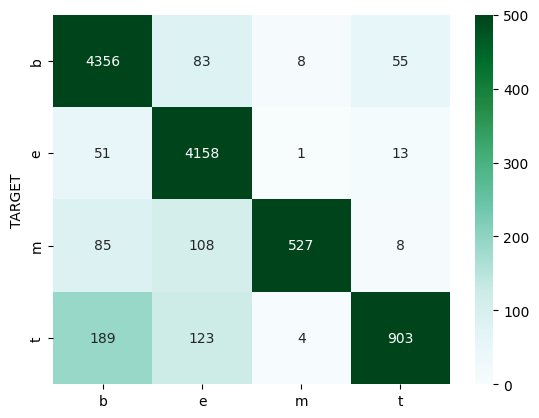

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

train_cm = confusion_matrix(train['CATEGORY'], train_pred)
cm = pd.DataFrame(train_cm, columns=['b', 'e', 'm', 't'])
cm['TARGET'] = ['b', 'e', 'm', 't']
cm = cm.set_index('TARGET')
sns.heatmap(cm, vmin=0, vmax=500, annot=True, fmt='d', cmap='BuGn')

confusion_matrix：混同行列を計算する。混同行列は、クラス分類モデルの性能を評価するために用いられる行列で、真陽性（True Positive）、真陰性（True Negative）、偽陽性（False Positive）、偽陰性（False Negative）の4つの値を含む。

行が実際のラベル、列が予測ラベル

seaborn：統計データ可視化のための Python のライブラリ

.heatmap()：行列データをカラーマップとして可視化するための関数

**56. 適合率，再現率，F1スコアの計測**

52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

適合率（precision）は、陽性と予測されたサンプルのうち正解したサンプルの割合。　→誤検出を下げる

再現率（recall）は実際に陽性のサンプルのうち正解したサンプルの割合。　→取りこぼしを下げる

F1値（F1-measure）は適合率と再現率の調和平均。

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test['CATEGORY'], test_pred, labels=['b', 'e', 'm', 't']))

              precision    recall  f1-score   support

           b       0.91      0.95      0.93       563
           e       0.91      0.98      0.94       528
           m       0.93      0.55      0.69        91
           t       0.86      0.66      0.75       152

    accuracy                           0.90      1334
   macro avg       0.90      0.79      0.83      1334
weighted avg       0.90      0.90      0.90      1334



classification_report：分類モデルの性能を評価するための詳細なレポートを生成するための関数

Support (サポート)： 各クラスにおける実際のサンプル数

m,tはサンプル数が少ないため特徴をうまく捉えられていなく見逃されているため再現率が低い。

**57. 特徴量の重みの確認**

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ

In [ ]:
feature_names = train_X.columns.values
for i in range(len(lg.classes_)):
    coef = lg.coef_[i]
    features = [(feature_names[j], np.abs(coef[j])) for j in range(len(feature_names))]
    print('カテゴリ: {} ================'.format(lg.classes_[i]))
    bests = sorted(features, key=lambda w: w[1], reverse=True)
    worsts = sorted(features, key=lambda w: w[1])
    print('重みの高いtop10')
    for k in range(10):
        print('{}\t{}\t{}'.format(k + 1, bests[k][0], bests[k][1]))
    print('重みの低いtop10')
    for k in range(10):
        print('{}\t{}\t{}'.format(k + 1, worsts[k][0], worsts[k][1]))

カテゴリ: b ================
重みの高いtop10
1	bank	3.6656788727766916
2	fed	3.2852083015416484
3	china	3.1298421551411657
4	ecb	2.992324207442487
5	ukrain	2.585280247009826
6	profit	2.5106040773935705
7	euro	2.4512973380529495
8	updat	2.425058775143569
9	oil	2.392535165480896
10	stock	2.3422407732557526
重みの低いtop10
1	normal	0.0006429383265896358
2	mysteri	0.0010066185598849435
3	process	0.001176270751156383
4	goal	0.0012648971572327818
5	with new	0.0014990316647759067
6	worth	0.0019143545051405054
7	real	0.0019931842912550373
8	of all	0.002125376698128702
9	senat	0.0021530198998697893
10	down in	0.002153912697465157
カテゴリ: e ================
重みの高いtop10
1	updat	3.1838866069446423
2	kardashian	2.757891487478053
3	googl	2.7450073774545136
4	us	2.6115857937963
5	film	2.5972507630655834
6	chri	2.5729017074668974
7	movi	2.4961558202789322
8	wed	2.26125551270936
9	china	2.223206412416776
10	studi	2.2226725938688374
重みの低いtop10
1	north	0.00022715040113206988
2	tear	0.000344558988653116
3	theori	0.0003590

.coef_：各特徴量の重みを取得
sorted(iterable, key=key, reverse=reverse)：

iterable: ソート対象のイテラブルなオブジェクト。

key (オプション): ソートの基準となる関数を指定。

reverse (オプション): True に設定すると降順にソート。

**58. 正則化パラメータの変更**

ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

100%|██████████| 10/10 [03:12<00:00, 19.20s/it]


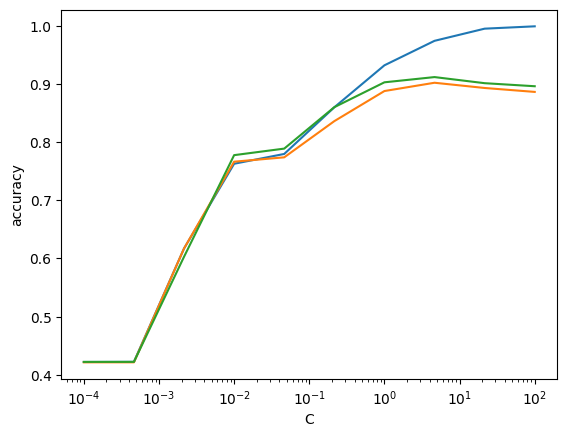

In [ ]:
from tqdm import tqdm
results = []
for c in tqdm(np.logspace(-4, 2, 10, base=10)):
    # モデルの学習
    lg = LogisticRegression(random_state=64, max_iter=10000, C=c)
    lg.fit(train_X, train['CATEGORY'])

    # 予測
    train_pred = lg.predict(train_X)
    valid_pred = lg.predict(valid_X)
    test_pred = lg.predict(test_X)

    # 評価
    train_acc = accuracy_score(train['CATEGORY'], train_pred)
    valid_acc = accuracy_score(valid['CATEGORY'], valid_pred)
    test_acc = accuracy_score(test['CATEGORY'], test_pred)
    results.append([c, train_acc, valid_acc, test_acc])

results = np.array(results)
fig, ax = plt.subplots()
ax.plot(results[:, 0], results[:, 1], label='train')
ax.plot(results[:, 0], results[:, 2], label='valid')
ax.plot(results[:, 0], results[:, 3], label='test')
ax.set_xlabel('C')
ax.set_ylabel('accuracy')
ax.set_xscale('log')
plt.show()

tqdm：進捗バーを提供するためのPythonのライブラリ
forループやイテレータなどの処理において、処理が進行中であるかどうかを可視化するのに利用

np.logspace()：対数スケールで等間隔に値を生成するNumPyの関数

.predict()：学習済みモデルを用いて入力データ X に対して予測を行う

青:train 橙:valid 緑:test

C=1〜10

**59. ハイパーパラメータの探索**

学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [ ]:
!pip install optuna

In [ ]:
import optuna

# 目的関数の設定
def objective(trial):
    # 探索変数
    c = trial.suggest_loguniform('C', 1, 1e1)

    # モデル
    lg = LogisticRegression(random_state=64,
                            max_iter=10000,
                            C=c,
                           )

    # 学習
    lg.fit(train_X, train['CATEGORY'])

    # 検証
    valid_pred = lg.predict(valid_X)
    valid_acc = accuracy_score(valid['CATEGORY'], valid_pred)
    return valid_acc

# 最適化
study = optuna.create_study(direction='maximize') #目的関数を最大化する方向で最適化
study.optimize(objective, timeout=30)

# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-12-14 01:24:03,629] A new study created in memory with name: no-name-19ffde39-c385-40bf-a86f-efe9d5becf0f
<ipython-input-36-ebdf70ef5b9a>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  c = trial.suggest_loguniform('C', 1, 1e1)
[I 2023-12-14 01:24:31,576] Trial 0 finished with value: 0.8950524737631185 and parameters: {'C': 1.324588224992812}. Best is trial 0 with value: 0.8950524737631185.
<ipython-input-36-ebdf70ef5b9a>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  c = trial.suggest_loguniform('C', 1, 1e1)
[I 2023-12-14 01:25:02,734] Trial 1 finished with value: 0.9010494752623688 and parameters: {'C': 3.429093950539938}. Best is trial 1 with value: 0.9010

Best trial:
  Value: 0.901
  Params: 
    C: 3.429093950539938


In [ ]:
# パラメータの設定
C = trial.params['C']

# モデルの学習
lg = LogisticRegression(random_state=123,
                        max_iter=10000,
                        C=C)
# 学習
lg.fit(train_X, train['CATEGORY'])

# 予測値の取得
train_pred = lg.predict(train_X)
valid_pred = lg.predict(valid_X)
test_pred = lg.predict(test_X)

# 正解率の算出
train_accuracy = accuracy_score(train['CATEGORY'], train_pred)
valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred)
test_accuracy = accuracy_score(test['CATEGORY'], test_pred)

print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（検証データ）：{valid_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

正解率（学習データ）：0.968
正解率（検証データ）：0.901
正解率（評価データ）：0.909


optuna：ベイズ最適化を使用してハイパーパラメータの最適化を行うためのライブラリ。ハイパーパラメータの探索空間を定義し、目的関数の最大化または最小化を試行錯誤的に進める。

.suggest_loguniform()：対数スケールで探索するためのハイパーパラメータの提案を行うメソッド

.create_study（）：新しいOptunaの研究を作成する関数

.optimize()：最適化を行うメソッド

.best_trial：最適な試行を取得するプロパティ